# Stochastic Gradient Langevin Dynamics in MXNet

In [2]:
%matplotlib inline

In this notebook, we will show how to replicate the toy example in the paper <a name="ref-1"/>[(Welling and Teh, 2011)](#cite-welling2011bayesian). Here we have observed 20 instances from a mixture of Gaussians with tied means:
$$
\begin{aligned}
\theta_1 &\sim N(0, \sigma_1^2)\\
\theta_2 &\sim N(0, \sigma_2^2)\\
x_i &\sim \frac{1}{2}N(0, \sigma_x^2) + \frac{1}{2}N(\theta_1 + \theta_2, \sigma_x^2)
\end{aligned}
$$
We are asked to draw samples from the posterior distribution $p(\theta_1, \theta_2 \mid X)$. In the following, we will use stochastic gradient langevin dynamics (SGLD) to do the sampling.

In [3]:
import mxnet as mx
import mxnet.ndarray as nd
import numpy
import logging
import time
import matplotlib.pyplot as plt


def load_synthetic(theta1, theta2, sigmax, num=20):
    flag = numpy.random.randint(0, 2, (num,))
    X = flag * numpy.random.normal(theta1, sigmax, (num, )) \
                    + (1.0 - flag) * numpy.random.normal(theta1 + theta2, sigmax, (num, ))
    return X.astype('float32')


class SGLDScheduler(mx.lr_scheduler.LRScheduler):
    def __init__(self, begin_rate, end_rate, total_iter_num, factor):
        super(SGLDScheduler, self).__init__()
        if factor >= 1.0:
            raise ValueError("Factor must be less than 1 to make lr reduce")
        self.begin_rate = begin_rate
        self.end_rate = end_rate
        self.total_iter_num = total_iter_num
        self.factor = factor
        self.b = (total_iter_num - 1.0) / ((begin_rate / end_rate) ** (1.0 / factor) - 1.0)
        self.a = begin_rate / (self.b ** (-factor))
        self.count = 0

    def __call__(self, num_update):
        self.base_lr = self.a * ((self.b + num_update) ** (-self.factor))
        self.count += 1
        return self.base_lr


def synthetic_grad(X, theta, sigma1, sigma2, sigmax, rescale_grad=1.0, grad=None):
    if grad is None:
        grad = nd.empty(theta.shape, theta.context)
    theta1 = theta.asnumpy()[0]
    theta2 = theta.asnumpy()[1]
    v1 = sigma1 **2
    v2 = sigma2 **2
    vx = sigmax **2
    denominator = numpy.exp(-(X - theta1)**2/(2*vx)) + numpy.exp(-(X - theta1 - theta2)**2/(2*vx))
    grad_npy = numpy.zeros(theta.shape)
    grad_npy[0] = -rescale_grad*((numpy.exp(-(X - theta1)**2/(2*vx))*(X - theta1)/vx
                + numpy.exp(-(X - theta1 - theta2)**2/(2*vx))*(X - theta1-theta2)/vx)/denominator).sum()\
                + theta1/v1
    grad_npy[1] = -rescale_grad*((numpy.exp(-(X - theta1 - theta2)**2/(2*vx))*(X - theta1-theta2)/vx)/denominator).sum()\
                + theta2/v2
    grad[:] = grad_npy
    return grad

We first write the generation process. In the paper, the data instances are generated with the following parameter, $\theta_1^2=10, \theta_2^2=1, \theta_x^2=2$.
Also, we need to write a new learning rate schedule as described in the paper $\epsilon_t = a(b+t)^{-r}$
and calculate the gradient. After these preparations, we can go on with the sampling process.

In [4]:
numpy.random.seed(100)
mx.random.seed(100)

theta1 = 0
theta2 = 1
sigma1 = numpy.sqrt(10)
sigma2 = 1
sigmax = numpy.sqrt(2)
X = load_synthetic(theta1=theta1, theta2=theta2, sigmax=sigmax, num=100)
minibatch_size = 1
total_iter_num = 1000000
lr_scheduler = SGLDScheduler(begin_rate=0.01, end_rate=0.0001, total_iter_num=total_iter_num,
                             factor=0.55)
optimizer = mx.optimizer.create('sgld',
                        learning_rate=None,
                        rescale_grad=1.0,
                        lr_scheduler=lr_scheduler,
                        wd=0)
updater = mx.optimizer.get_updater(optimizer)
theta = mx.random.normal(0, 1, (2,), ctx=mx.cpu())
grad = nd.empty((2,), mx.cpu())
samples = numpy.zeros((2, total_iter_num))
start = time.time()
for i in range(total_iter_num):
    if (i+1)%100000 == 0:
        end = time.time()
        print("Iter:%d, Time spent: %f" %(i + 1, end-start))
        start = time.time()
    ind = numpy.random.randint(0, X.shape[0])
    synthetic_grad(X[ind], theta, sigma1, sigma2, sigmax, rescale_grad=
                            X.shape[0] / float(minibatch_size), grad=grad)
    updater('theta', grad, theta)
    samples[:, i] = theta.asnumpy()

Iter:100000, Time spent: 21.831000
Iter:200000, Time spent: 21.752000
Iter:300000, Time spent: 21.982000
Iter:400000, Time spent: 21.866000
Iter:500000, Time spent: 21.835000
Iter:600000, Time spent: 21.917000
Iter:700000, Time spent: 22.352000
Iter:800000, Time spent: 21.952000
Iter:900000, Time spent: 21.885000
Iter:1000000, Time spent: 21.919000


We have collected 1000000 samples in the **samples** variable. Now we can draw the density plot. For more about SGLD, the original paper and <a name="ref-2"/>[(Neal, 2011)](#cite-neal2011mcmc) are good references.

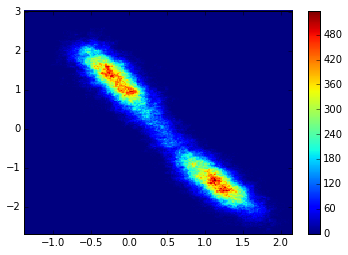

In [5]:
plt.hist2d(samples[0, :], samples[1, :], (200, 200), cmap=plt.cm.jet)
plt.colorbar()
plt.show()

<!--bibtex
@inproceedings{welling2011bayesian,
  title={Bayesian learning via stochastic gradient Langevin dynamics},
  author={Welling, Max and Teh, Yee W},
  booktitle={Proceedings of the 28th International Conference on Machine Learning (ICML-11)},
  pages={681--688},
  url="http://www.icml-2011.org/papers/398_icmlpaper.pdf",
  year={2011}
}

@article{neal2011mcmc,
  title={MCMC using Hamiltonian dynamics},
  author={Neal, Radford M and others},
  journal={Handbook of Markov Chain Monte Carlo},
  volume={2},
  pages={113--162},
  url="www.mcmchandbook.net/HandbookChapter5.pdf",
  year={2011}
}

-->

# References

<a name="cite-welling2011bayesian"/><sup>[^](#ref-1) </sup>Welling, Max and Teh, Yee W. 2011. _Bayesian learning via stochastic gradient Langevin dynamics_. [URL](http://www.icml-2011.org/papers/398_icmlpaper.pdf)

<a name="cite-neal2011mcmc"/><sup>[^](#ref-2) </sup>Neal, Radford M and others. 2011. _MCMC using Hamiltonian dynamics_. [URL](www.mcmchandbook.net/HandbookChapter5.pdf)

